In [1]:
# data manipulation
import pandas as pd
import numpy as np
import scipy

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# machine learning
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, chi2, mutual_info_classif
from xgboost import XGBClassifier
from joblib import load

# misc.
import os
import copy
from modules import gendata, cm_metrics
from datetime import datetime, timedelta

In [2]:
# ipython magic
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# matlpotlib properties
plt.rcParams["figure.figsize"] = 6,6
plt.rcParams["figure.dpi"] = 150
plt.rcParams['figure.max_open_warning'] = False
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# seaborn properties
sns.set(style="whitegrid")

In [ ]:
df = pd.read_csv('./Refined_SPADE_Year20182019_Ver20210307.csv')
df = df.set_index('StudyID')
print(df.shape)
print(df.columns)
feature_columns_cont = [
     'ed_inp_delta'
    ,'ed_duration'
    ,'elix_score'
    ,'age_val'
]
feature_columns_cat = [
     'img_flags'
    ,'con_flags'
]
print(df.PatientSSN.unique().shape)
feature_columns = [
     'ed_duration'
    ,'ed_inp_delta'
    ,'age_val'
    ,'img_flags'
    ,'con_flags'
    ,'elix_score'
]
df[feature_columns]

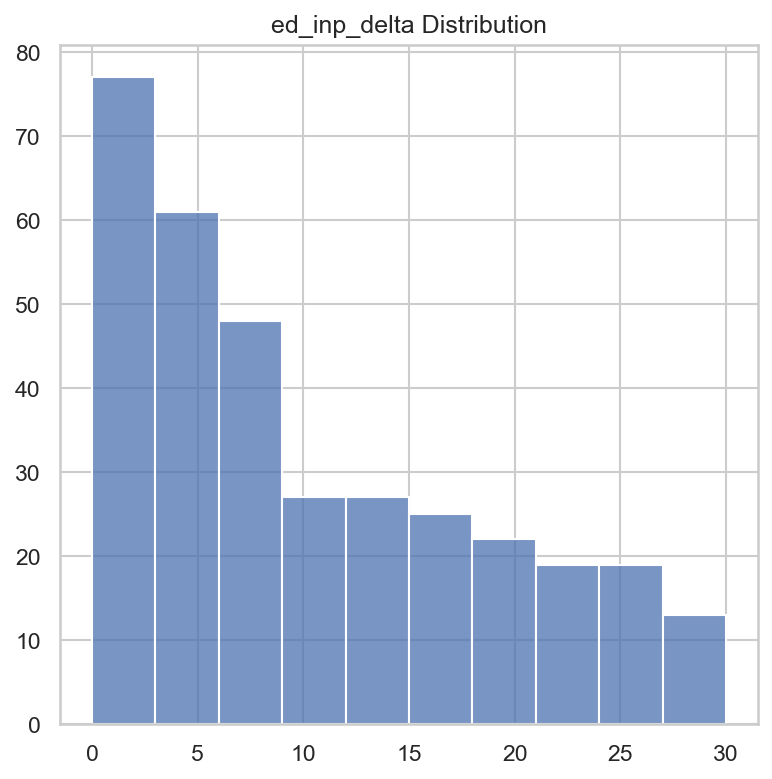

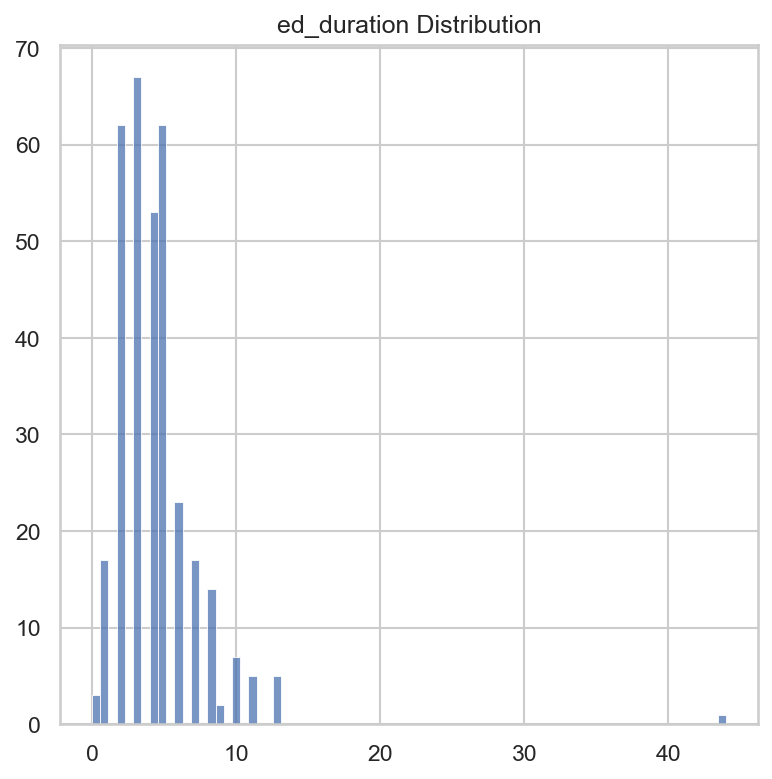

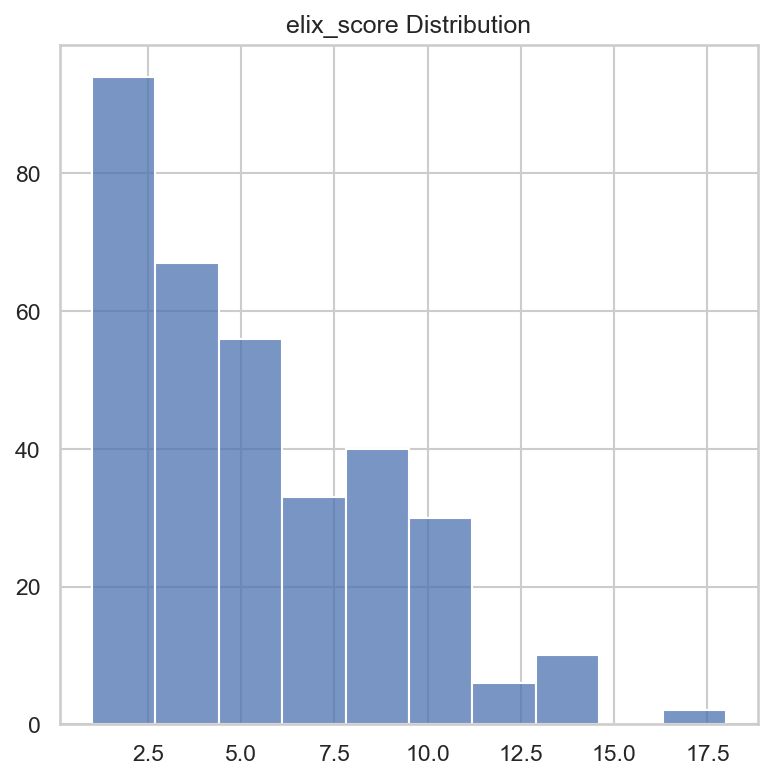

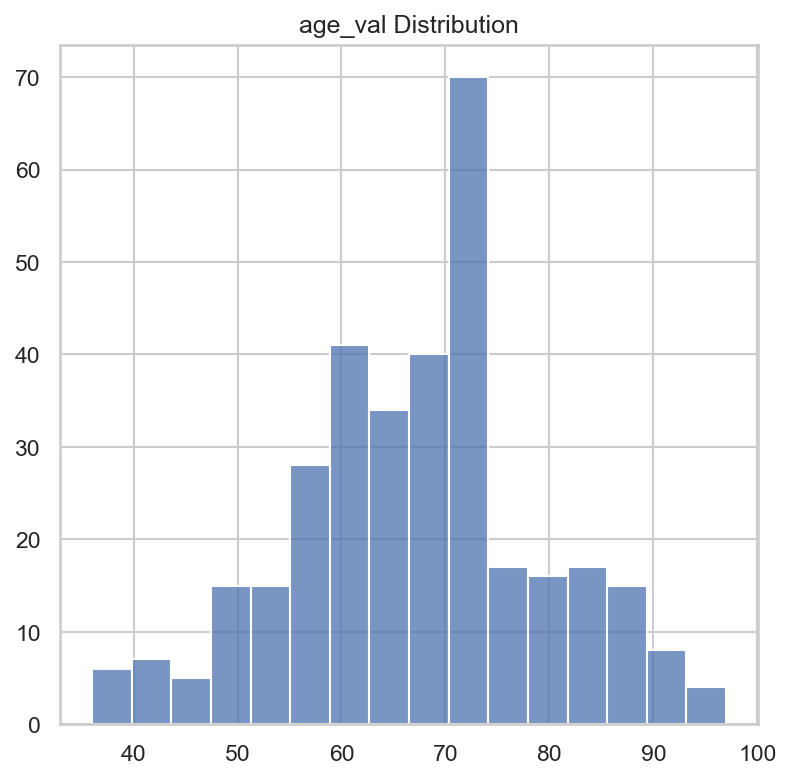

In [4]:
for col in feature_columns_cont:

    # Create figure variables
    fldist_fig, fldist_axes = plt.subplots()
    sns.histplot(data=df, x=col, ax=fldist_axes)

    # Set text
    fldist_axes.set_title(col + ' Distribution')
    fldist_axes.set_ylabel('')
    fldist_axes.set_xlabel('')
    fldist_fig.set_figheight(6)
    fldist_fig.set_figwidth(6)

In [5]:
elixscaler = MinMaxScaler().fit(df['elix_score'].values.reshape(-1,1))
agescaler  = MinMaxScaler().fit(df['age_val'].values.reshape(-1,1))
ed_durationscaler  = MinMaxScaler().fit(df['ed_duration'].values.reshape(-1,1))
ed_inp_deltascaler = MinMaxScaler().fit(df['ed_inp_delta'].values.reshape(-1,1))
df['ed_inp_delta'] = MinMaxScaler().fit_transform(df['ed_inp_delta'].values.reshape(-1,1))
df['ed_duration'] = MinMaxScaler().fit_transform(df['ed_duration'].values.reshape(-1,1))
df['elix_score'] = MinMaxScaler().fit_transform(df['elix_score'].values.reshape(-1,1))
df['age_val'] = MinMaxScaler().fit_transform(df['age_val'].values.reshape(-1,1))

In [6]:
clf = load('saved_model_217samples_124pos_93neg.joblib')

In [ ]:
probs = clf.predict_proba(df[feature_columns])[:,1]
rankeddf = df.copy()
rankeddf.insert(len(rankeddf.columns), 'P(MOD)', probs)
rankeddf.head()

In [8]:
pd.concat([rankeddf.sort_values('P(MOD)').iloc[:10], rankeddf.sort_values('P(MOD)').iloc[-10:]]).to_csv("./rankedSPADEtrigger_notunique.csv")

In [ ]:
rankeddf.sort_values('P(MOD)').iloc[-10:]

In [10]:
dftest = rankeddf.copy()
dftest = dftest.reset_index()
#dftest = df.set_index(['StudyID', 'PatientSSN'])
multi = dftest.set_index(['PatientSSN', 'StudyID'])
multi2 = dftest.set_index(['PatientSSN', 'PatientArrivalDateTime'])

In [11]:
multi = multi.sort_values(by='P(MOD)')

In [ ]:
%%time
multi2 = multi2.sort_values(by='P(MOD)')
idxmax = {key:[None, 0] for key in multi2.index.values}
for ii,i in enumerate(multi2.iterrows()):
    if idxmax[i[0]][1] < i[1]['P(MOD)']:
        idxmax.update({i[0]:[ii, i[1]['P(MOD)']]})
uniquedatetime = multi2.iloc[np.asarray(list(idxmax.values()))[:,0].astype(int)]
uniquedatetime

In [ ]:
forchartreview = pd.concat([uniquedatetime.iloc[-10:], uniquedatetime.iloc[np.random.randint(12,290)]

In [ ]:
multi.loc[multi['Pat']]

In [142]:
ranks = multi.loc[multi['P(MOD)'].groupby(level=0).idxmax()].sort_values(by='P(MOD)')

In [ ]:
ranks

In [152]:
np.argmax(multi.index.get_level_values('StudyID').isin([3251]))

288

In [98]:
rdf = pd.concat([ranks.iloc[-10:], ranks.iloc[:10]])

In [100]:
rdf = rdf.sort_values(by='P(MOD)')

In [ ]:
rdf

In [94]:
rdf.to_csv('./rankedSPADEtrigger_new.csv')

In [102]:
results = pd.read_csv('./rankedSPADEtrigger_notunique.csv')

In [ ]:
results

In [179]:
bot10means = results.iloc[:10].mean(axis=0)
top10means = results.iloc[-10:].mean(axis=0)
print(bot10means - top10means)
print(bot10means.age_val.reshape(1,-1) - top10means.age_val.reshape(1,-1))
print(agescaler.inverse_transform(bot10means.age_val.reshape(1,-1)), agescaler.inverse_transform(top10means.age_val.reshape(1,-1)))
print(agescaler.inverse_transform(bot10means.age_val.reshape(1,-1)) - agescaler.inverse_transform(top10means.age_val.reshape(1,-1)))
print(elixscaler.inverse_transform(bot10means.elix_score.reshape(1,-1)), elixscaler.inverse_transform(top10means.elix_score.reshape(1,-1)))
print(elixscaler.inverse_transform(bot10means.elix_score.reshape(1,-1)) - elixscaler.inverse_transform(top10means.elix_score.reshape(1,-1)))
print(ed_durationscaler.inverse_transform(bot10means.ed_duration.reshape(1,-1)), ed_durationscaler.inverse_transform(top10means.ed_duration.reshape(1,-1)))
print(ed_durationscaler.inverse_transform(bot10means.ed_duration.reshape(1,-1)) - ed_durationscaler.inverse_transform(top10means.ed_duration.reshape(1,-1)))
print(ed_inp_deltascaler.inverse_transform(bot10means.ed_inp_delta.reshape(1,-1)), ed_inp_deltascaler.inverse_transform(top10means.ed_inp_delta.reshape(1,-1)))
print(ed_inp_deltascaler.inverse_transform(bot10means.ed_inp_delta.reshape(1,-1)) - ed_inp_deltascaler.inverse_transform(top10means.ed_inp_delta.reshape(1,-1)))

StudyID        -4.760000e+01
ed_duration     4.318182e-02
age_val        -4.147541e-01
ed_inp_delta   -2.000000e-02
img_flags       1.000000e+00
con_flags       1.000000e+00
elix_score     -4.352941e-01
PatientSSN     -7.344625e+07
P(MOD)         -6.361853e-01
dtype: float64
[[-0.4147541]]
[[58.9]] [[84.2]]
[[-25.3]]
[[2.1]] [[9.5]]
[[-7.4]]
[[5.8]] [[3.9]]
[[1.9]]
[[9.2]] [[9.8]]
[[-0.6]]


In [156]:
results.iloc[-10:].mean(axis=0)

StudyID         3.174100e+03
ed_duration     8.863636e-02
age_val         7.901639e-01
ed_inp_delta    3.266667e-01
img_flags       0.000000e+00
con_flags       0.000000e+00
elix_score      5.000000e-01
PatientSSN      3.599399e+08
P(MOD)          7.801773e-01
dtype: float64

In [158]:
clf.coef_

array([[ 1.16347598, -0.29301865,  1.17064657, -1.22139931, -1.03072637,
         0.86680646]])

In [181]:
for i in zip(df[feature_columns].columns, *clf.coef_):
    print(i)

('ed_duration', 1.1634759782264477)
('ed_inp_delta', -0.29301865225014506)
('age_val', 1.1706465706175626)
('img_flags', -1.221399305598307)
('con_flags', -1.0307263716020745)
('elix_score', 0.8668064635773864)
